##### bibiotecas#######

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as utils
import os
import numpy as np
#from datetime import datetime
#from PIL import Image
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import seaborn as sns
#from sklearn.manifold import TSNE
#import warnings
#import plotly.express as px
from tqdm import tqdm

##### database loader #######

In [3]:
label_NSC = ['nuvem','Solo_exposto','Cultivo'] # NSC Nuvem, Solo_exposto e Cultivo
label_NNoN = ['nuvem','noNuvem'] # noNuvem = Solo_exposto e Cultivo
label_SEC = ['Solo_exposto','Cultivo']

#tensor das bandas 3000, 128, 128, 3 # no caso dos dados reais nao vai usar a labels
train_tensor= np.load('/content/drive/MyDrive/Data-bayer/imagem_sem_mascara/TALHAO_130_sem_norm_sem_mask_talhao_images.npy')
#Label para test
train_labels = np.load('/content/drive/MyDrive/Data-bayer/imagem_sem_mascara/TALHAO_130_sem_norm_sem_mask_talhao_nome.npy')

n_classe = 2 # classe de cada modelo que foi treainado

print(train_tensor.shape)

t, w, h, c = train_tensor.shape
dataTensor= train_tensor.reshape(t,c,w,h) # reshape 128, 128, 3 => 3, 128, 128 troca da posição da banda

print(dataTensor.shape)


(126, 128, 128, 3)
(126, 3, 128, 128)


In [ ]:
print(train_labels)

In [ ]:
tensor_x_train = torch.Tensor(dataTensor) #convertendo para tensor do pytorch 
tensor_y_train = torch.Tensor(train_labels)

#tensor_x_train_n = normalize(tensor_x_train)

#tensor_x_test = torch.Tensor(teste_data) 
#tensor_y_test = torch.Tensor(teste_label)

#tensor_x_test_n = normalize(tensor_x_test)


test_dataset = TensorDataset(tensor_x_train,tensor_y_train) # create your datset
#test_dataset = TensorDataset(tensor_x_test,tensor_y_test) # create your datset

#train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset,batch_size=1, shuffle=True, num_workers=0) 

#####Model#######

In [ ]:
# Não alterar alterar a estrutura do modelo
print('==> Building model..')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = torchvision.models.resnet50()
modules = list(net.children())[:-1]
modules.append(nn.Flatten())
modules.append(nn.Linear(net.fc.in_features,n_classe))
net = nn.Sequential(*modules)
model_nNon = net.to(device)

print(device)

model_nNon.load_state_dict(torch.load("/content/drive/MyDrive/Data-bayer/imagem_sem_mascara/model/Seed_15-02-2023_13-55-15_Renset50_model.pt",map_location=device)) # carregar o modelo treinado "CNN"





==> Building model..
cuda


<All keys matched successfully>

In [ ]:
# Não alterar a estrutura do do modelo
print('==> Building model..')

net_ = torchvision.models.resnet50()
modules_ = list(net_.children())[:-1]
modules_.append(nn.Flatten())
modules_.append(nn.Linear(net_.fc.in_features,n_classe))
net_ = nn.Sequential(*modules_)

model_SeCultivo = net_.to(device)

print(device)

model_SeCultivo.load_state_dict(torch.load("/content/drive/MyDrive/Data-bayer/imagem_sem_mascara/model/Seed_15-02-2023_14-50-45_Renset50_model.pt",map_location=device)) 



==> Building model..
cuda


<All keys matched successfully>

##### Bloco de inference######

In [ ]:
# remover apenas a linha label.append(int(targets.data.cpu().numpy())) e  label = []
#targets será usado como nome do arquivo a interar e o input é o tensor de cada npz

"""
        Parameters: 
        ---------------
            data_loader: dataset dos tensores com label ou nome do arquivo.

        Return:
         ---------------
            predicted para 3 classes nuvem, SE and cultivo.
"""

def Inference_(data_loader):

    model_nNon.eval()
    model_SeCultivo.eval()
    pred = []
    label = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(data_loader), 0):
        #for batch_idx, (inputs, targets) in enumerate(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs_nNon = model_nNon(inputs)
            outputs_SeCultivo = model_SeCultivo(inputs)

            label.append(int(targets.data.cpu().numpy()))

            _nNon, predictednNon = outputs_nNon.max(1)
            _Sec, predictedSec = outputs_SeCultivo.max(1)

            if((predictednNon.data.cpu().numpy()[0]) == label_NNoN.index('nuvem')):
              pred.append(predictednNon.data.cpu().numpy()[0])

            else:

              if((predictedSec.data.cpu().numpy()[0]) == label_SEC.index('Solo_exposto')):
                #print('SE')
                pred.append((predictedSec.data.cpu().numpy()[0])+1)

              elif((predictedSec.data.cpu().numpy()[0]) == label_SEC.index('Cultivo')):
                pred.append((predictedSec.data.cpu().numpy()[0])+1)         

        return pred, label

In [ ]:
pred, label = Inference_(test_loader)

100%|██████████| 3000/3000 [01:01<00:00, 48.70it/s]


In [ ]:
print(np.unique(pred))

[0 1 2]


In [ ]:
confusion = confusion_matrix(label, pred)
print(confusion)

print ("Accuracy = ", metrics.accuracy_score(label, pred))
print ("Recall = ", metrics.recall_score(label, pred, average = None))
print ("Precision = ", metrics.precision_score(label, pred, average = None))
print ("F1 = ", metrics.f1_score(label, pred, average = None))

[[985   8   7]
 [ 15 973  12]
 [ 64  25 911]]
Accuracy =  0.9563333333333334
Recall =  [0.985 0.973 0.911]
Precision =  [0.92575188 0.96719682 0.97956989]
F1 =  [0.95445736 0.97008973 0.94404145]


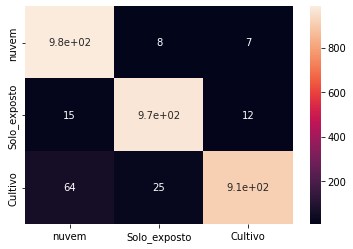

In [ ]:
sns.heatmap(confusion, annot=True,  xticklabels=label_NSC, yticklabels=label_NSC)